# Brier Skill Score (BSS) Analysis for Weather Analogues

This notebook analyzes the performance of different weather analogue methods using the Brier Skill Score (BSS). The BSS measures the relative improvement of a forecast method compared to a reference method.

## Analysis Components

1. **Precipitation Analysis**: Compares the skill of different analogue methods in forecasting precipitation events
   - Calculates BSS for various precipitation thresholds
   - Evaluates performance across spatial and temporal dimensions

2. **Multi-Variable Analysis**: Examines performance across different meteorological variables
   - Calculates BSS for each variable (d2m, u, v, msl, r)
   - Provides time series and aggregated comparisons

## Methods Compared

The primary comparison is between:
- **AtmoDist-SW**: Spatially weighted neural network-based similarity measure
- **Cosine**: Traditional cosine similarity measure (used as reference)

## Notebook Structure

1. **Setup and Data Loading**
   - Import libraries and configure environment
   - Load ERA5 data and event information
   - Prepare analogue results for analysis

2. **Precipitation BSS Analysis**
   - Calculate Brier Scores for different precipitation thresholds
   - Generate BSS comparing the weighted method to the cosine method

3. **Multi-Variable BSS Analysis**
   - Calculate variable-specific Brier Scores
   - Visualize BSS across variables and time steps

In [1]:
"""
Import necessary libraries for the Brier Skill Score (BSS) analysis.
Libraries are grouped by purpose for better organization.
"""

# Standard library imports
import json
import os
import sys

# Data processing and analysis
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style for better readability
plt.style.use('seaborn-v0_8')
sns.set_context("talk")

# Third-party library imports
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import h5py
import matplotlib.dates
import xarray as xr
from matplotlib.ticker import FormatStrFormatter
from sklearn import preprocessing
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine
from skimage.metrics import structural_similarity as ssim

# PyTorch related imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchmetrics
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset

# PyTorch Lightning related imports
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger, Logger

# Wandb (Weights & Biases) related imports
import wandb

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [2]:
"""
Setup the environment and import project-specific utility functions.
"""

def setup_environment():
    """
    Set up the working environment by changing to the project root directory
    and adding project paths to sys.path.
    
    Returns:
        str: Current working directory
    """
    try:
        os.chdir("../")
    except:
        pass
    current_directory = os.getcwd()
    print("Current Directory:", current_directory)
    sys.path.append(os.path.abspath(os.path.join(current_directory, "notebooks")))
    return current_directory

# Configure the environment
current_directory = setup_environment()

# Import only the necessary project utilities
from utils.utils_data import read_netcdf
from utils.utils_analog import attach_data_to_analogs


Current Directory: /home/yuhan/Desktop/Master/yu-ml-weather-analogue


## Process Data


### -Load ERA5 Data

In [3]:
"""
Load ERA5 meteorological data for analysis.
"""

def get_data_paths(variables, selected_frequency, time_unit, resample_method, preprocessing_method, year_range):
    """
    Generate file paths for ERA5 data with different preprocessing methods.
    
    Args:
        variables (str): String containing variable codes
        selected_frequency (int): Data frequency
        time_unit (str): Time unit ('h' for hour)
        resample_method (str): Method used for resampling
        preprocessing_method (str): Preprocessing method applied to data
        year_range (tuple): Start and end year (inclusive)
        
    Returns:
        tuple: Paths for raw, standardized, normalized, and precipitation data
    """
    base_path = f"../data/processed/{variables}_{selected_frequency}{time_unit}_{resample_method}"
    raw_path = f"{base_path}_{preprocessing_method}_{year_range[0]}{year_range[1]}.h5"
    standardized_path = f"{base_path}_standardized_{year_range[0]}{year_range[1]}.h5"
    normalized_path = f"{base_path}_normalized_{year_range[0]}{year_range[1]}.h5"
    
    # Path for precipitation data
    prep_path = f"../data/processed/tp_{selected_frequency}{time_unit}_{resample_method}_{preprocessing_method}_{year_range[0]}{year_range[1]}.h5"
    
    return raw_path, standardized_path, normalized_path, prep_path

# Define meteorological variables and configuration parameters
variable_list = ["d2m", "u", "v", "msl", "r"]
variables = ''.join(variable_list)
selected_frequency = 1
time_unit = "h"
resample_method = "none"
preprocessing_method = "raw"
year_range = (2004, 2020)

# Generate data paths
all_variables_data_path, all_variables_standardized_data_path, all_variables_normalized_data_path, prep_path = get_data_paths(
    variables, selected_frequency, time_unit, resample_method, preprocessing_method, year_range
)

# Load data
all_variables_data = read_netcdf(all_variables_data_path)
prep_data = read_netcdf(prep_path)

# Note: The following standardized and normalized data are not used in this analysis
# all_variables_standardized_data = read_netcdf(all_variables_standardized_data_path)
# all_variables_normalized_data = read_netcdf(all_variables_normalized_data_path)

### -Load Events

In [5]:
"""
Load event data and grid weights for analysis.
"""

def load_events_data(events_path):
    """
    Load and preprocess historical events data.
    
    Args:
        events_path (str): Path to the events CSV file
        
    Returns:
        pandas.DataFrame: Processed events dataframe with datetime columns
    """
    events_df = pd.read_csv(events_path)
    # Sort events by start datetime in ascending order
    events_df = events_df.sort_values(by="start datetime")
    # Convert string datetime to pandas datetime objects
    events_df["start datetime"] = pd.to_datetime(events_df["start datetime"])
    events_df["end datetime"] = pd.to_datetime(events_df["end datetime"])
    return events_df

def load_grid_weights(weights_path, threshold=0.0030):
    """
    Load grid weights and identify important grid points based on threshold.
    
    Args:
        weights_path (str): Path to the weights JSON file
        threshold (float): Threshold for identifying important grid points
        
    Returns:
        tuple: Grid weights array and list of indices above threshold
    """
    with open(weights_path, 'r') as f:
        loaded_data = json.load(f)
    
    grid_weights = np.array(loaded_data['grid_weights'])
    
    # Identify important grid points (above threshold)
    flattened_grid_weights = grid_weights.ravel()
    indices_above_threshold = np.where(flattened_grid_weights > threshold)[0]
    local_indices_list = indices_above_threshold.tolist()
    
    return grid_weights, flattened_grid_weights, local_indices_list

# Load event data
events_df = load_events_data("data/raw/events_flood.csv")

# Load grid weights and identify important grid points
grid_weights, flattened_grid_weights, local_indices_list = load_grid_weights(
    'data/raw/weights.json', 
    threshold=0.0030
)

# Define a specific grid point of interest (row 16, column 14 in a 32x32 grid)
specified_index = 16*32+14


# Precipitation


## BS + BSS

In [6]:
"""
Load analogue search results for precipitation analysis.
"""

def load_analogue_results(project, method, event_index, data):
    """
    Load analogue search results for a specific method and event.
    
    Args:
        project (str): Project name for the analogue results
        method (str): Similarity method name
        event_index (int): Index of the event to analyze
        data (dict): Data to attach to the analogues
        
    Returns:
        dict: Analogue results with attached data
    """
    directory = f'../data/analogs/{project}'
    file_path = f'{directory}/{method}.json'
    
    with open(file_path, 'r') as f:
        all_results = json.load(f)
    
    # Get results for the specified event
    analogs_single_event = all_results[event_index]
    
    # Attach data to analogues for analysis
    analogue_results_with_data = attach_data_to_analogs(
        data,
        analogs_single_event
    )
    
    return analogue_results_with_data

def extract_ensemble_data(analogue_results, num_analogues=6):
    """
    Extract observed data and analogue ensemble from results.
    
    Args:
        analogue_results (dict): Analogue results with attached data
        num_analogues (int): Number of analogues to include in ensemble
        
    Returns:
        tuple: Observed data array and analogue ensemble array
    """
    keys = list(analogue_results.keys())
    observed = np.array(analogue_results["0"]["data"])
    analogue_ensemble = np.array([np.array(analogue_results[key]["data"]) for key in keys[1:num_analogues+1]])
    
    return observed, analogue_ensemble

# Configuration
project = "first_stage"
event_index = 42  # Selected flood event to analyze

# Load weighted similarity analogues
weighted_analogue_results = load_analogue_results(
    project, 
    "weighted_similarity", 
    event_index, 
    prep_data
)

# Load cosine similarity analogues
cosine_analogue_results = load_analogue_results(
    project, 
    "cosine_similarity", 
    event_index, 
    prep_data
)

# Extract observed data and analogue ensembles
observed, weighted_analogue_ensemble = extract_ensemble_data(weighted_analogue_results)
_, cosine_analogue_ensemble = extract_ensemble_data(cosine_analogue_results)

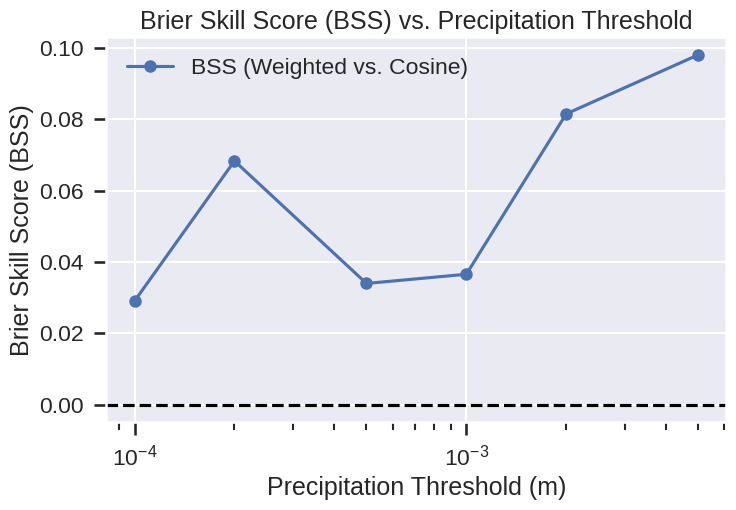

In [7]:
"""
Calculate and visualize Brier Scores and Brier Skill Scores for precipitation.
"""

def compute_brier_score(observed, analogue_ensemble, threshold):
    """
    Calculate the Brier Score (BS) for precipitation forecasts.
    
    Args:
        observed (ndarray): Observed precipitation data, shape (7, 1, 32, 32)
        analogue_ensemble (ndarray): Analogue ensemble data, shape (6, 7, 1, 32, 32)
        threshold (float): Precipitation threshold in meters
        
    Returns:
        float: Brier Score (lower is better)
    """
    # Step 1: Convert observed data to binary (precipitation event: 1, no event: 0)
    observed_binary = (observed >= threshold).astype(int)
    
    # Step 2: Calculate probability of precipitation from the ensemble
    # (fraction of ensemble members exceeding the threshold)
    forecast_prob = (analogue_ensemble >= threshold).mean(axis=0)
    
    # Step 3: Calculate Brier Score (mean squared error of probabilities)
    brier_score = np.mean((forecast_prob - observed_binary) ** 2)
    
    return brier_score

def calculate_brier_skill_score(method1_bs, method2_bs):
    """
    Calculate Brier Skill Score comparing two methods.
    
    Args:
        method1_bs (list): Brier Scores for first method (typically the one being evaluated)
        method2_bs (list): Brier Scores for second method (typically the reference method)
        
    Returns:
        list: Brier Skill Scores (positive values indicate improvement over reference)
    """
    # Calculate BSS: 1 - (BS_method1 / BS_method2)
    # Positive values indicate method1 outperforms method2
    bss_values = [1 - (m1_bs / m2_bs) if m2_bs > 0 else np.nan 
                 for m1_bs, m2_bs in zip(method1_bs, method2_bs)]
    return bss_values

def plot_bss_vs_threshold(thresholds, bss_values, title=None):
    """
    Plot Brier Skill Score vs precipitation threshold.
    
    Args:
        thresholds (list): Precipitation thresholds
        bss_values (list): Brier Skill Scores
        title (str, optional): Plot title
    """
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, bss_values, marker='o', linestyle='-', label="BSS (Weighted vs. Cosine)")
    plt.xscale('log')  # Use logarithmic scale for thresholds
    plt.xlabel("Precipitation Threshold (m)")
    plt.ylabel("Brier Skill Score (BSS)")
    plt.title(title or "Brier Skill Score (BSS) vs. Precipitation Threshold")
    plt.axhline(y=0, color='black', linestyle='--')  # Add reference line at BSS=0
    plt.legend()
    plt.grid(True)
    plt.show()

# Define precipitation thresholds to evaluate (in meters)
thresholds = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005]

# Calculate Brier Scores for both methods across thresholds
weighted_bs_values = [compute_brier_score(observed, weighted_analogue_ensemble, t) for t in thresholds]
cosine_bs_values = [compute_brier_score(observed, cosine_analogue_ensemble, t) for t in thresholds]

# Calculate Brier Skill Scores (weighted method compared to cosine method)
bss_values = calculate_brier_skill_score(weighted_bs_values, cosine_bs_values)

# Plot the results
plot_bss_vs_threshold(thresholds, bss_values)


# Variables

# BS + BSS

In [8]:
"""
Load and analyze meteorological variables using Brier Score approach.
"""

def load_variable_analogues(project, method, event_index, data):
    """
    Load analogue results for variable analysis.
    
    Args:
        project (str): Project name
        method (str): Similarity method name
        event_index (int): Event index to analyze
        data (dict): Variable data to attach
        
    Returns:
        tuple: Observed data and analogue ensemble arrays
    """
    # Load analogue results
    directory = f'../data/analogs/{project}'
    file_path = f'{directory}/{method}.json'
    with open(file_path, 'r') as f:
        all_results = json.load(f)
    analogs_single_event = all_results[event_index]
    
    # Attach variable data to analogues
    analogue_results_with_data = attach_data_to_analogs(data, analogs_single_event)
    
    # Extract data arrays
    keys = list(analogue_results_with_data.keys())
    observed = np.array(analogue_results_with_data["0"]["data"])
    analogue_ensemble = np.array([np.array(analogue_results_with_data[key]["data"]) for key in keys[1:7]])
    
    return observed, analogue_ensemble

def calculate_variable_brier_scores(observed, analogue_ensemble):
    """
    Calculate Brier Scores for meteorological variables.
    
    Args:
        observed (ndarray): Observed variable data
        analogue_ensemble (ndarray): Analogue ensemble data
        
    Returns:
        tuple: Target values (ones), probabilities, Brier Scores, and mean Brier Scores
    """
    # Print data shapes for debugging
    print("observed shape:", observed.shape)
    print("ensemble shape:", analogue_ensemble.shape)
    
    # Create target array (ones)
    O = np.ones(observed.shape)
    print("Target shape:", O.shape)
    
    # Calculate standard deviation for each variable (across time and space)
    delta_v = np.std(observed, axis=(0, 2, 3))
    
    # Calculate absolute residuals between ensemble and observed
    residuals = np.abs(analogue_ensemble - observed)
    
    # Identify similar members (where residual <= standard deviation)
    similar_members = (residuals <= delta_v[:, None, None]).astype(int)
    print("similar_members shape:", similar_members.shape)
    
    # Calculate probability (mean of similar members)
    P = np.mean(similar_members, axis=0)
    print("Probability shape:", P.shape)
    
    # Calculate Brier Score: (P - O)²
    BS = (P - O) ** 2
    print("BS shape:", BS.shape)
    
    # Calculate mean BS for each variable
    BS_mean = np.mean(BS, axis=(0, 2, 3))
    print("BS_mean shape:", BS_mean.shape)
    
    return O, P, BS, BS_mean

# Configuration
project = "first_stage"
event_index = 24

# Process weighted similarity analogues
print("Processing weighted similarity analogues:")
weighted_observed, weighted_ensemble = load_variable_analogues(
    project, "weighted_similarity", event_index, all_variables_data
)
_, _, weighted_BS, weighted_BS_mean = calculate_variable_brier_scores(
    weighted_observed, weighted_ensemble
)
print(weighted_BS_mean)

print("#"*50)

# Process cosine similarity analogues
print("Processing cosine similarity analogues:")
cosine_observed, cosine_ensemble = load_variable_analogues(
    project, "cosine_similarity", event_index, all_variables_data
)
_, _, cosine_BS, cosine_BS_mean = calculate_variable_brier_scores(
    cosine_observed, cosine_ensemble
)
print(cosine_BS_mean)

print("#"*50)

# Calculate Brier Skill Scores (weighted vs. cosine)
BSS_weighted = 1 - (np.array(weighted_BS_mean) / np.array(cosine_BS_mean))
print("Brier Skill Scores (weighted vs. cosine):")
print(BSS_weighted)


Processing weighted similarity analogues:
observed shape: (7, 5, 32, 32)
ensemble shape: (6, 7, 5, 32, 32)
Target shape: (7, 5, 32, 32)
similar_members shape: (6, 7, 5, 32, 32)
Probability shape: (7, 5, 32, 32)
BS shape: (7, 5, 32, 32)
BS_mean shape: (5,)
[0.4933772  0.16651941 0.08022538 0.19004991 0.19868009]
##################################################
Processing cosine similarity analogues:
observed shape: (7, 5, 32, 32)
ensemble shape: (6, 7, 5, 32, 32)
Target shape: (7, 5, 32, 32)
similar_members shape: (6, 7, 5, 32, 32)
Probability shape: (7, 5, 32, 32)
BS shape: (7, 5, 32, 32)
BS_mean shape: (5,)
[0.4933772  0.16651941 0.08022538 0.19004991 0.19868009]
##################################################
Processing cosine similarity analogues:
observed shape: (7, 5, 32, 32)
ensemble shape: (6, 7, 5, 32, 32)
Target shape: (7, 5, 32, 32)
similar_members shape: (6, 7, 5, 32, 32)
Probability shape: (7, 5, 32, 32)
BS shape: (7, 5, 32, 32)
BS_mean shape: (5,)
[0.45028444 0.382095

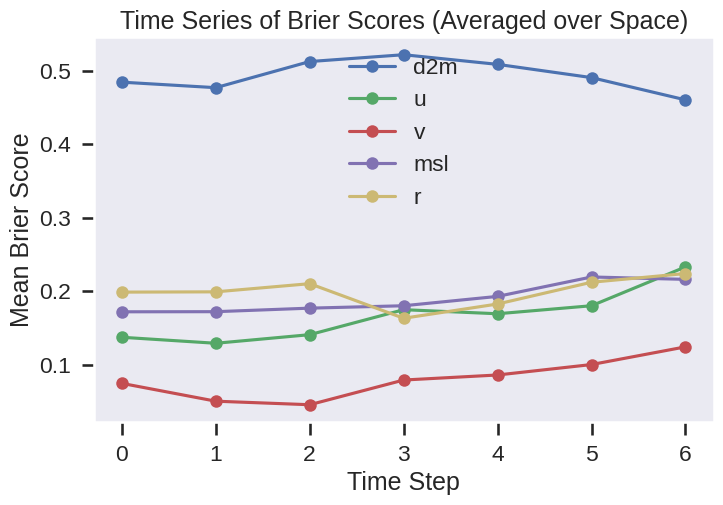

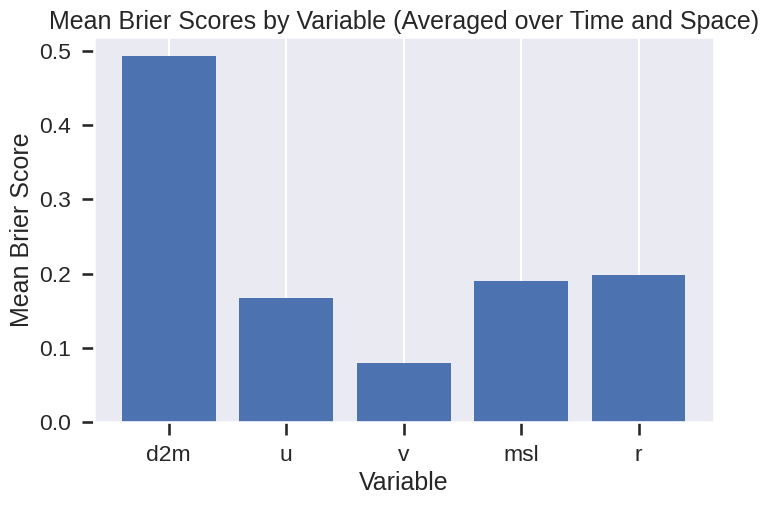

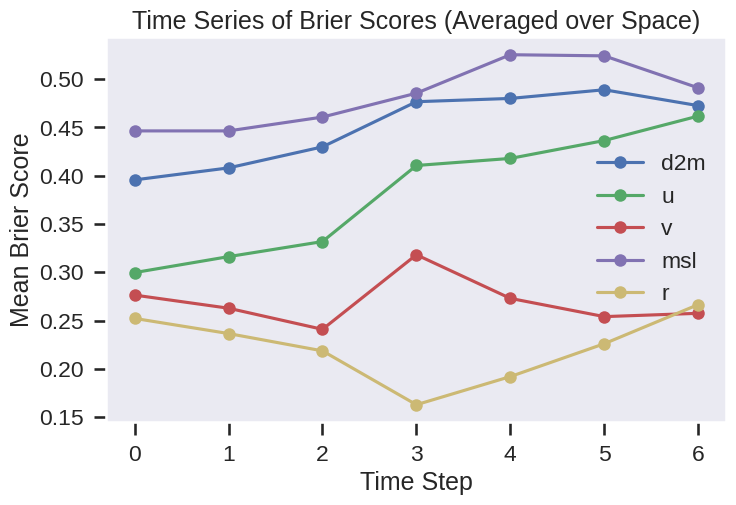

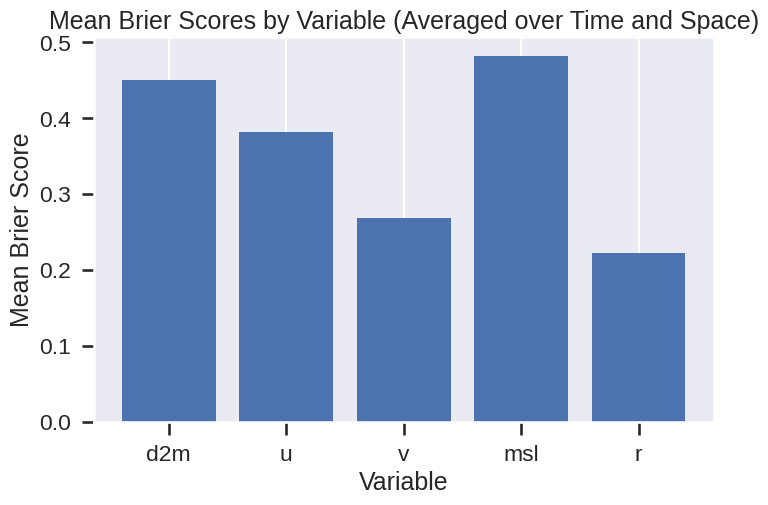

In [9]:
import numpy as np
import matplotlib.pyplot as plt

"""
Visualize Brier Score data for different variables and methods.
"""

def plot_bs_data(BS, variable_list, plot_type):
    """
    Plot Brier Score data according to the specified plot type.
    
    Args:
        BS (ndarray): Brier Score data with shape (time_steps, variables, lat, lon)
        variable_list (list): List of variable names
        plot_type (str): Type of plot to generate:
            - 'time_series': Time series plot (averaged over space)
            - 'spatial': Spatial distribution (averaged over time)
            - 'variable_bs': Bar chart of BS per variable (averaged over time and space)
    """
    num_time, num_vars, lat_size, lon_size = BS.shape

    if plot_type == "time_series":
        # Time series plot: Average over spatial dimensions (32x32)
        bs_time_series = BS.mean(axis=(2, 3))  # shape (7, 5)
        
        plt.figure(figsize=(8, 5))
        for i, var in enumerate(variable_list):
            plt.plot(range(num_time), bs_time_series[:, i], marker='o', linestyle='-', label=var)
        plt.xlabel("Time Step")
        plt.ylabel("Mean Brier Score")
        plt.title("Time Series of Brier Scores (Averaged over Space)")
        plt.legend()
        plt.grid()
        plt.show()
    
    elif plot_type == "spatial":
        # Spatial distribution: Average over time steps
        bs_spatial = BS.mean(axis=0)  # shape (5, 32, 32)
        
        for i, var in enumerate(variable_list):
            plt.figure(figsize=(6, 5))
            plt.imshow(bs_spatial[i, :, :], cmap="coolwarm", origin="lower")
            plt.colorbar(label=f"Variable {var} Mean BS")
            plt.xlabel("Longitude")
            plt.ylabel("Latitude")
            plt.title(f"Spatial Distribution of BS for {var} (Averaged over Time)")
            plt.show()
    
    elif plot_type == "variable_bs":
        # Variable BS: Average over all time steps and spatial dimensions
        bs_variable = BS.mean(axis=(0, 2, 3))  # shape (5,)
        
        plt.figure(figsize=(8, 5))
        plt.bar(range(num_vars), bs_variable)
        plt.xlabel("Variable")
        plt.ylabel("Mean Brier Score")
        plt.title("Mean Brier Scores by Variable (Averaged over Time and Space)")
        plt.xticks(range(num_vars), labels=variable_list)
        plt.grid(axis='y')
        plt.show()
    
    else:
        print("Invalid plot_type. Choose from 'time_series', 'spatial', or 'variable_bs'.")

# Plot time series of Brier Scores for weighted method
plot_bs_data(weighted_BS, variable_list, "time_series")

# Plot Brier Scores by variable for weighted method
plot_bs_data(weighted_BS, variable_list, "variable_bs")

# Plot time series of Brier Scores for cosine method
plot_bs_data(cosine_BS, variable_list, "time_series")

# Plot Brier Scores by variable for cosine method
plot_bs_data(cosine_BS, variable_list, "variable_bs")

# Note: Spatial plots are commented out as they generate multiple figures
# plot_bs_data(weighted_BS, variable_list, "spatial")


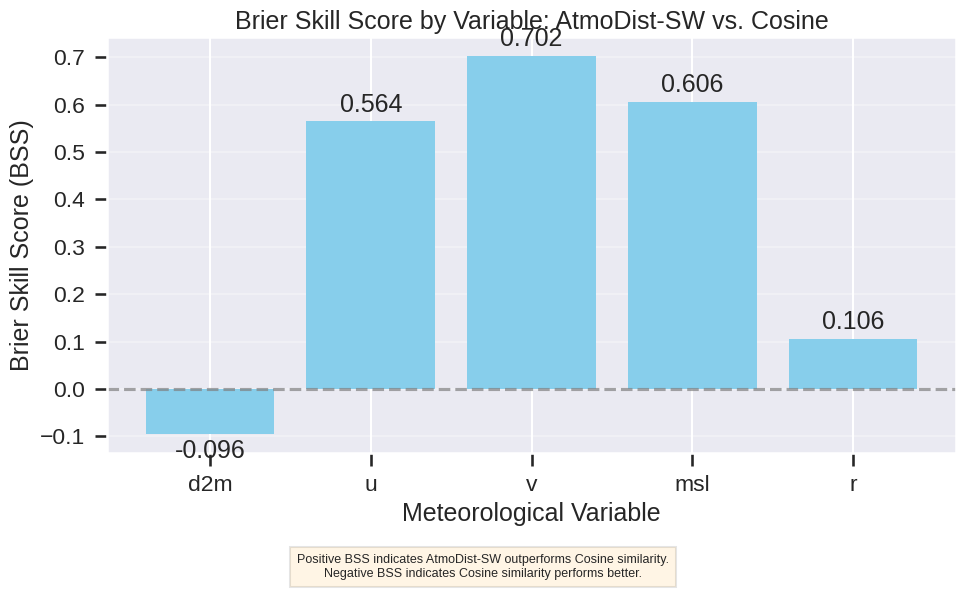

In [10]:
"""
Visualize Brier Skill Score (BSS) for each variable using bar charts.
"""

def plot_bss_bar_chart(weighted_BS, cosine_BS, variable_list):
    """
    Calculate and plot Brier Skill Score (BSS) for each variable.
    
    Args:
        weighted_BS (ndarray): Weighted method's Brier Scores, shape (time_steps, variables, lat, lon)
        cosine_BS (ndarray): Cosine method's Brier Scores, shape (time_steps, variables, lat, lon)
        variable_list (list): List of variable names
    """
    # Calculate mean BS for each variable (averaged over time and space)
    weighted_bs_avg = weighted_BS.mean(axis=(0, 2, 3))  # shape (5,)
    cosine_bs_avg = cosine_BS.mean(axis=(0, 2, 3))  # shape (5,)

    # Calculate BSS (avoid division by zero)
    epsilon = 1e-8
    bss_per_variable = 1 - (weighted_bs_avg / (cosine_bs_avg + epsilon))

    # Create bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(bss_per_variable)), bss_per_variable, color="skyblue")
    
    # Add value labels on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., 
                 height + 0.01 * (1 if height >= 0 else -1),
                 f'{bss_per_variable[i]:.3f}',
                 ha='center', va='bottom' if height >= 0 else 'top')
    
    # Add horizontal line at BSS=0
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
    
    # Set labels and title
    plt.xlabel("Meteorological Variable")
    plt.ylabel("Brier Skill Score (BSS)")
    plt.title("Brier Skill Score by Variable: AtmoDist-SW vs. Cosine")
    plt.xticks(range(len(bss_per_variable)), labels=variable_list)
    plt.grid(axis='y', alpha=0.3)
    
    # Add explanatory text
    plt.figtext(0.5, 0.01, 
                "Positive BSS indicates AtmoDist-SW outperforms Cosine similarity.\n" +
                "Negative BSS indicates Cosine similarity performs better.", 
                ha="center", fontsize=9, bbox={"facecolor":"orange", "alpha":0.1, "pad":5})
    
    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make room for the text
    plt.show()

# Plot BSS bar chart comparing weighted method to cosine method
plot_bss_bar_chart(weighted_BS, cosine_BS, variable_list)